In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold 

## a) load/merge data and visualize logerror

In [2]:
# load data into DataFrames
train = pd.read_csv("/home/akshay/Downloads/MAIL/HW5/HW5/q2_data/train.csv")
properties = pd.read_csv("/home/akshay/Downloads/MAIL/HW5/HW5/q2_data/properties.csv")
data_pd = train.merge(properties, on="id", how="inner")
data = data_pd.to_numpy()

In [3]:
# eliminate outliers
# taking column 2, which is the log error
one_percent = np.percentile(data[:,1], 1)
ninety_nine_percent = np.percentile(data[:,1], 99)
low_idx = np.where(data[:,1] < one_percent)
high_idx = np.where(data[:,1] > ninety_nine_percent)
data[low_idx, 1] = one_percent 
data[high_idx, 1] = ninety_nine_percent

Text(0, 0.5, 'Log-error')

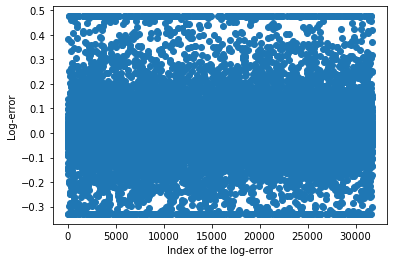

In [4]:
# scatter of logerr
data_no = np.arange(1, data.shape[0]+1)
fig1, ax1 = plt.subplots(1)
ax1.scatter(data_no, data[:, 1])
ax1.set_xlabel("Index of the log-error")
ax1.set_ylabel("Log-error")

Text(0, 0.5, 'log-error')

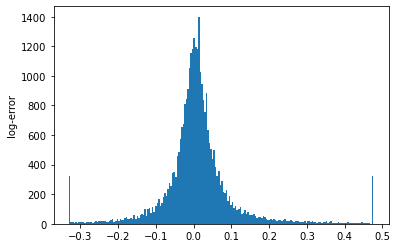

In [5]:
# histogram of logerr
fig2, ax2 = plt.subplots(1)
ax2.hist(data[:,1], bins="auto")
ax2.set_ylabel("log-error")

## b) data cleaning

In [6]:
#assisgning the updated column to the data_frame
data_pd.iloc[:,1] = data[:,1]

In [7]:
# build new data frame
clean_df = pd.DataFrame(columns=['column_name', 'missing_count'])
clean_df['column_name'] = [*data_pd]
missing_count = []

for column in [*data_pd]:
    missing_count.append(data_pd[column].isnull().sum())

clean_df['missing_count'] = missing_count
clean_df.iloc[:5,:]

missing_ratio = []
total_no_of_data = data_pd.shape[0]

for column, miss_count in zip([*data_pd], missing_count):
    missing_ratio.append((miss_count / total_no_of_data))

clean_df['missing_ratio'] = missing_ratio


In [8]:
# fill missing data
i = 0
for column, miss_no in zip(data_pd, clean_df['missing_count']): 
    i += 1
    if pd.api.types.is_numeric_dtype(data_pd[column]) and miss_no != 0:
        col_mean = data_pd[column].mean()
        idx = pd.isna(data_pd[column])
        data_pd[column].iloc[idx] = col_mean
    
#print(data_pd.iloc[:1][:])

/home/akshay/anaconda3/envs/cve/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## c) univariate analysis

0.006561980129046172 id
0.00632751143687425 airconditioningtypeid
-0.001233864838286728 architecturalstyletypeid
0.005238522619389635 basementsqft
0.033445022352849414 bathroomcnt
0.03216818790391722 bedroomcnt
nan buildingclasstypeid
-0.001839668292540492 buildingqualitytypeid
0.03434458555574457 calculatedbathnbr
nan decktypeid
0.000806680347630661 finishedfloor1squarefeet
0.04284113799626631 calculatedfinishedsquarefeet
0.03950434052382624 finishedsquarefeet12
0.012608065999967201 finishedsquarefeet13
0.01468666231333262 finishedsquarefeet15
0.0006214820079056785 finishedsquarefeet50
-0.000655915058639708 finishedsquarefeet6
0.007862640449805601 fips
0.0050994131654547034 fireplacecnt
0.032985811417016356 fullbathcnt
-3.923165394283734e-05 garagecarcnt
0.005227481132968134 garagetotalsqft
-0.01951067953867454 heatingorsystemtypeid
0.003277310285116709 latitude
0.0077821661685649815 longitude
0.00609256083520044 lotsizesquarefeet
nan poolcnt
-0.0014421181560562095 poolsizesum
nan poo

((53,), 53)

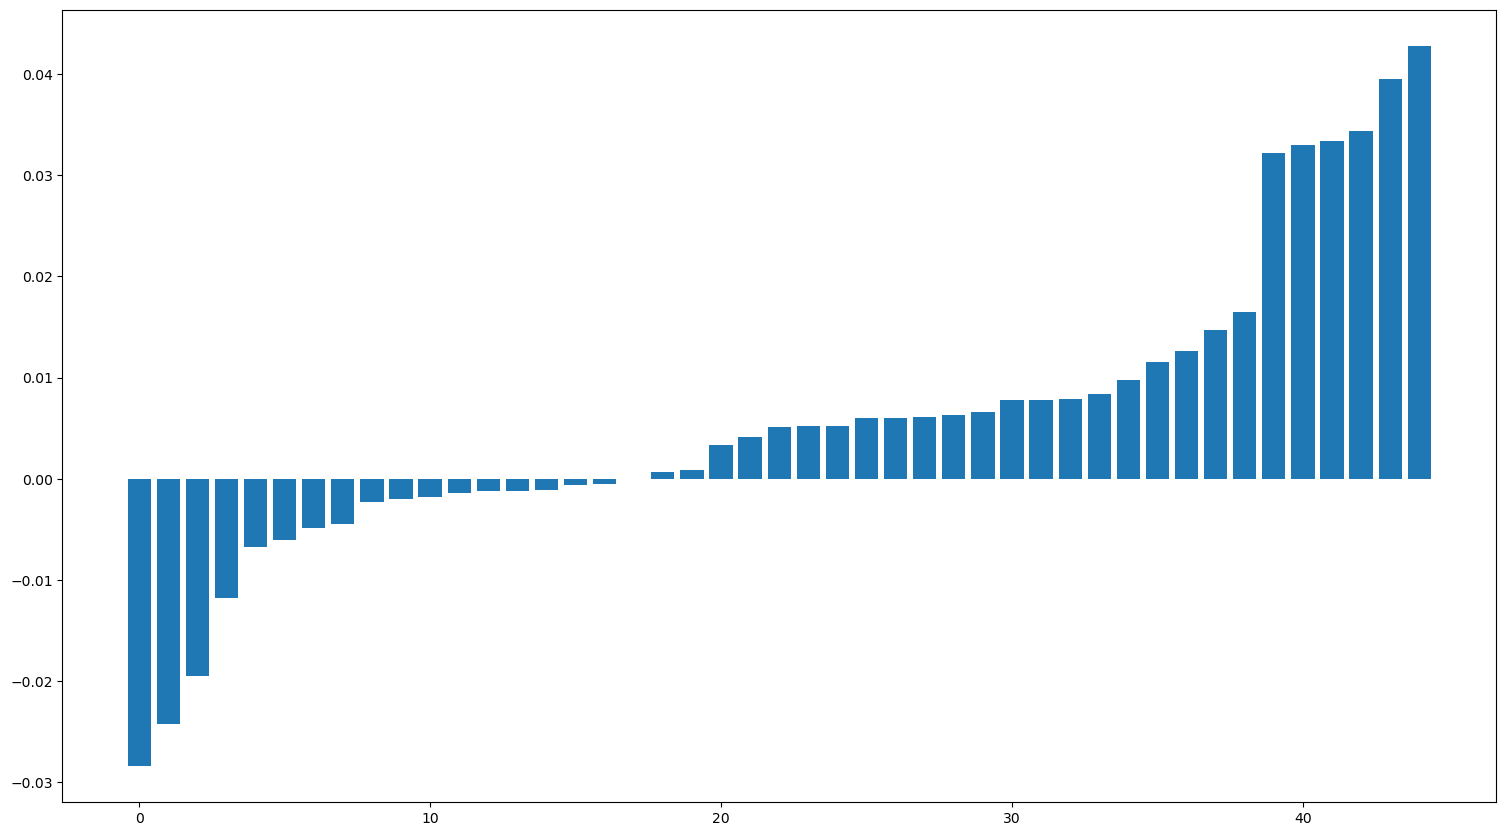

In [65]:
# make bar chart

correlation = []
logerror_column = pd.DataFrame(data_pd['logerror'])
columns = []

# for each column finding the correlation
for column in data_pd:
    if pd.api.types.is_numeric_dtype(data_pd[column]) and column != 'logerror':
        temp_df = pd.DataFrame(data_pd[column])
        corr_curr = (data_pd[column].astype('float64').corr(data_pd['logerror'].astype('float64')))
        correlation.append(corr_curr)
        columns.append(column)
        print(corr_curr, column)

correlation = np.asarray(correlation)
correlation = np.sort(correlation)

x_coords = np.arange(0, correlation.shape[0])

fig, ax = plt.subplots(1)
ax.bar(x_coords, correlation, align='center') 
fig.set_size_inches(18.5, 10.5)

fig.set_dpi(100)
#plot below
correlation.shape, len(columns)

# explain reason
Some features have correlation as 'nan' in the above calculation. There are namely, pooltypeid10,pooltypeid2,pooltypeid7
assessmentyear etc. This shows that there is no relation between log error and these variables. Precisely, the change to log-error
cannot be related in anyway to these features. This is because these feature are like id's or assessmentyear or types, which cannot directly
contribute to the regression problem. These are more of idendifier features. So there change is independent of the change of log-error

## d) non-linear regression model

In [27]:
# drop categorical features 
# ("hashottuborspa", "propertycountylandusecode", "propertyzoningdesc", "fireplaceflag", "taxdelinquencyflag") 
# drop "id" and "transactiondate"
columns_to_drop = ["hashottuborspa", 'propertycountylandusecode', 'propertyzoningdesc', 'fireplaceflag', 
                   'taxdelinquencyflag', 'id', 'transactiondate', 'logerror']

data_n_ = data_pd.drop(columns_to_drop, axis = 1)
data_n_.shape 

(31725, 52)

In [28]:
y = data_pd['logerror']

In [29]:
#converting to numpy
data_n = data_n_.to_numpy()

In [50]:
# split and train
X_train, X_test, y_train, y_test = train_test_split(data_n, y, test_size=0.30, random_state=2)
random_forest_clf = RandomForestRegressor(n_estimators=10)
random_forest_clf.fit(X_train, y_train)
print("Train Score:", random_forest_clf.score(X_train, y_train), "Test Score:", random_forest_clf.score(X_test, y_test))

Train Score: 0.8002237693795773 Test Score: -0.13100544955322402


In [51]:
def calculate_mse(X_test, y_test, random_forest_clf):
    y_pred = random_forest_clf.predict(X_test)
    mse_ = np.sum(np.power(y_test - y_pred, 2)) / y_test.shape[0]
    return mse_

# report importances and msedata_pd


In [52]:
mse_loss_ = calculate_mse(X_test, y_test, random_forest_clf)
feature_importance = random_forest_clf.feature_importances_
# feature_importance_args = np.argsort(feature_importance)
print("MSE_loss:", mse_loss_)

MSE_loss: 0.011309687526971694


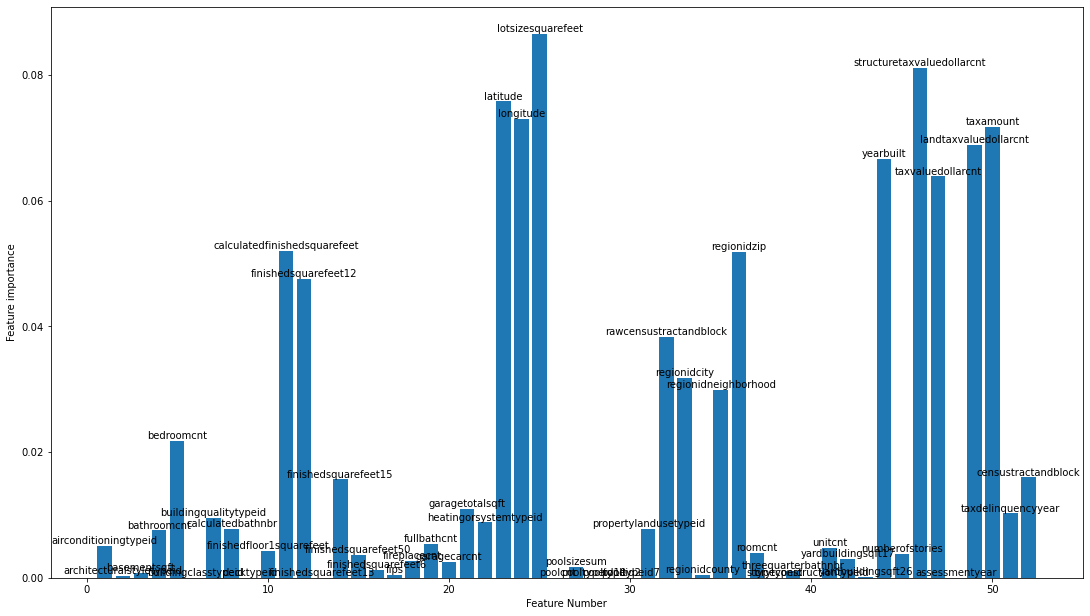

In [53]:
# plotting bar charts
x_coords = np.arange(1,53,1)
s = list(data_n_.columns)

fig, ax = plt.subplots(1)
line = ax.bar(x_coords, feature_importance)
ax.set_xlabel('Feature Number')
ax.set_ylabel("Feature importance")
fig.set_size_inches(18.5, 10.5)

for i in range(len(s)):
    ax.annotate(str(s[i]), xy=(x_coords[i],feature_importance[i]), ha='center', va='bottom')

plt.show()

## e) KFold

In [66]:
# KFold, k = 5
# taking the first 500 samples 
X_k_fold = data_n[:500, :]
y_k_fold = y[:500]
mse_loss_list = []
kf = KFold(5)
random_forest_clf_kf = RandomForestRegressor(n_estimators=10)

for train_index, test_index in kf.split(X_k_fold):
    X_train_kf, X_test_kf = X_k_fold[train_index], X_k_fold[test_index]
    y_train_kf, y_test_kf = y_k_fold[train_index], y_k_fold[test_index]
    random_forest_clf_kf.fit(X_train_kf, y_train_kf)
    mse_loss_list.append(calculate_mse(X_test_kf, y_test_kf, random_forest_clf_kf))

overall_mse_loss_kf = sum(mse_loss_list) / len(mse_loss_list)
print("overall Loss:", overall_mse_loss_kf)

overall Loss: 0.014702641136324312


In [56]:
def random_forest(data_n, y, r):
    X_train, X_test, y_train, y_test = train_test_split(data_n, y, test_size=0.30, random_state=r)
    random_forest_clf = RandomForestRegressor(n_estimators=10, random_state=r)
    random_forest_clf.fit(X_train, y_train)
    #calculating the mse of test 
    return calculate_mse(X_test, y_test, random_forest_clf)

In [59]:
# Run d2 for 100 times
mse_loss_100 = []
for i in range(100):
    mse_loss_100.append(random_forest(data_n, y, i))
    print("Iteration/Random State:", i, ", MSE_LOSS:", mse_loss_100[i])


Iteration/Random State: 0 , MSE_LOSS: 0.011352893200932699
Iteration/Random State: 1 , MSE_LOSS: 0.011245934026848845
Iteration/Random State: 2 , MSE_LOSS: 0.011260543458676628
Iteration/Random State: 3 , MSE_LOSS: 0.011231872059675673
Iteration/Random State: 4 , MSE_LOSS: 0.010864840322324374
Iteration/Random State: 5 , MSE_LOSS: 0.0113770708898309
Iteration/Random State: 6 , MSE_LOSS: 0.011463349780889379
Iteration/Random State: 7 , MSE_LOSS: 0.011251050441579293
Iteration/Random State: 8 , MSE_LOSS: 0.011262338272529409
Iteration/Random State: 9 , MSE_LOSS: 0.011066511139263038
Iteration/Random State: 10 , MSE_LOSS: 0.011045854514874498
Iteration/Random State: 11 , MSE_LOSS: 0.011165183919149226
Iteration/Random State: 12 , MSE_LOSS: 0.010625989603921212
Iteration/Random State: 13 , MSE_LOSS: 0.011404065131116437
Iteration/Random State: 14 , MSE_LOSS: 0.011241071940108642
Iteration/Random State: 15 , MSE_LOSS: 0.011140717880262295
Iteration/Random State: 16 , MSE_LOSS: 0.01098434546

# Advantage of Cross Validation
As the cross validation divides data into k-folds, all the data will come under training and validation, so the model learns more from the data and avoids over fitting to train set. It will give a more accurate measure of the loss, and both train and test data are considered, while without kfold, only the train data is considred by the model while training.